In [2]:
import json
import os
from datetime import datetime
from multiprocessing.pool import ThreadPool

In [3]:
PARALLEL_PROCESSES = 16

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import shape

In [59]:
def compute_occupied_area(features):
    """
    Returns occupied area for list of features in square km
    """
    occupied = features
    geom = [shape(i['geometry']) for i in occupied]
    gdf = gpd.GeoDataFrame({'geometry': geom}, crs='EPSG:4326')
    # https://stackoverflow.com/questions/38961816/geopandas-set-crs-on-points
    #gdf = gdf.to_crs('EPSG:3857')  # convert to metric projection
    # Use CEA instead:
    gdf = gdf.to_crs({'proj':'cea'})
    # https://gis.stackexchange.com/questions/254413/how-to-fix-hole-lies-outside-shell
    # https://gis.stackexchange.com/questions/253224/geopandas-buffer-using-geodataframe-while-maintaining-the-dataframe
    gdf['geometry'] = gdf.geometry.buffer(0)
    joined = gdf.dissolve(by=None)
    return float(round(joined.area, 2) / 1e6)

In [60]:
def process_item(args):
    idx, filename = args
    print(f"(Processing {idx}", end='\r')
    with open(os.path.join('data', filename)) as f:
        data = json.load(f)
    id_ = filename.split('.json')[0]
    date = datetime.strptime(id_, '%Y-%m-%d')
    # https://gis.stackexchange.com/questions/329349/calculating-the-area-by-square-feet-with-geopandas
    area = compute_occupied_area(data['value']['features'])  
    return [id_, date, area, data['value']['features']]

In [61]:
processed = []
files = os.listdir('data')

def dispatch(items):
    print(f"Processing all {len(items)} items...")
    return list(ThreadPool(
        PARALLEL_PROCESSES).imap_unordered(process_item, enumerate(items)))

In [65]:
# XXX Slow...
#processed = dispatch(files)

In [66]:
import pickle

In [67]:
#with open('dump.pickle', 'wb') as f:
#    pickle.dump(processed, f)

In [68]:
with open('dump.pickle', 'rb') as f:
    processed = pickle.load(f)

# Plotting total territory control

In [69]:
df = pd.DataFrame(processed, columns=['id', 'date', 'area', 'features'])
df = df.drop(['id'], axis=1)
df = df.sort_values(by='date', ascending = True)

In [70]:
df = df.set_index('date')

In [71]:
df['area'] = df['area'].astype('float')

<AxesSubplot: xlabel='Date', ylabel='Russian-occupied Ukrainian territory in km²'>

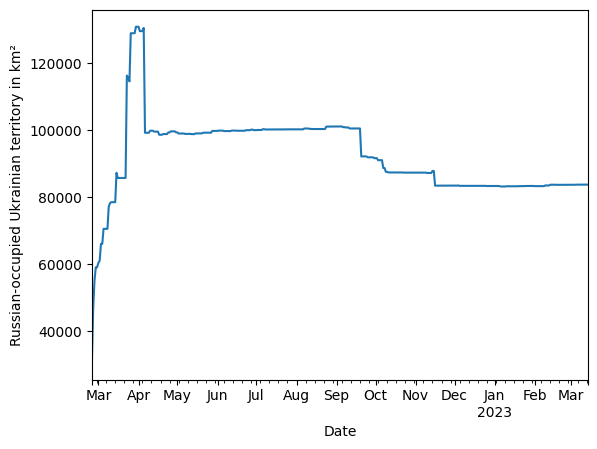

In [72]:
df['area'].plot(xlabel='Date', ylabel='Russian-occupied Ukrainian territory in km\u00b2')

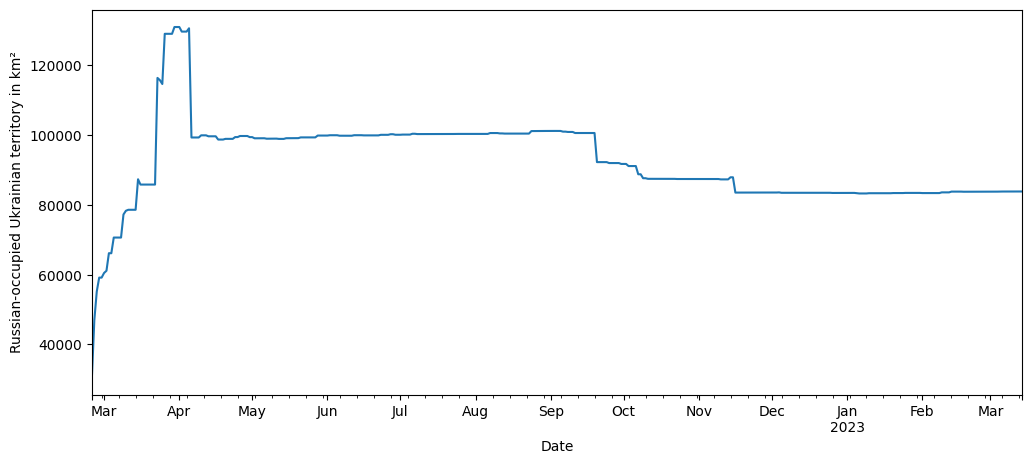

In [73]:
plt.figure()
df['area'].plot(xlabel='Date', ylabel='Russian-occupied Ukrainian territory in km\u00b2', figsize=(12, 5))
plt.savefig('nzz_area_total.png', bbox_inches='tight', dpi=600)

In [74]:
df['area'].to_csv('nzz_area_occupied.csv')
df['area'].to_json('nzz_area_occupied.json', date_format='iso', indent=2)
df.to_excel('nzz_area_occupied.xlsx')

# Mapping territory

In [75]:
from ipyleaflet import Map, GeoData, GeoJSON, basemaps, MagnifyingGlass, basemap_to_tiles, LayerGroup, SplitMapControl
import ipywidgets

In [76]:
selection_slider = ipywidgets.SelectionSlider(options=list(df.index),
                                              value=datetime(2022, 2, 24),
                                              description='Slider',
                                              disabled=False,
                                              continuous_update=False,
                                              orientation='horizontal',
                                              readout=True)

In [77]:
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(48.1928465, 37.8562077), zoom=5)

bg = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
m.add_layer(bg)

layer_group = LayerGroup(layers=[])
m.add_layer(layer_group)

def plot_date(date):
    entry = df.loc[df.index == date]
    idx, row = next(entry.iterrows())
    fc =   {
        'type': 'FeatureCollection',
        'features': row.loc['features'],
    }
    geo_json = GeoJSON(
        data=fc,
    )
    # Clear potential overlays from previous day selection
    #m.clear_layers()
    layer_group.clear_layers()
    layer_group.add_layer(geo_json)

ipywidgets.interact(plot_date, date=selection_slider)
display(m)

#control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
#m.add_control(control)

interactive(children=(SelectionSlider(continuous_update=False, description='Slider', options=(Timestamp('2022-…

Map(center=[48.1928465, 37.8562077], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [78]:
layer_group = LayerGroup(layers=[])
layer_group.clear_layers()

# Plotting territory control change

In [79]:
# Calculate change to previous day which translates to daily gains/losses
df['change'] = df['area'].diff()

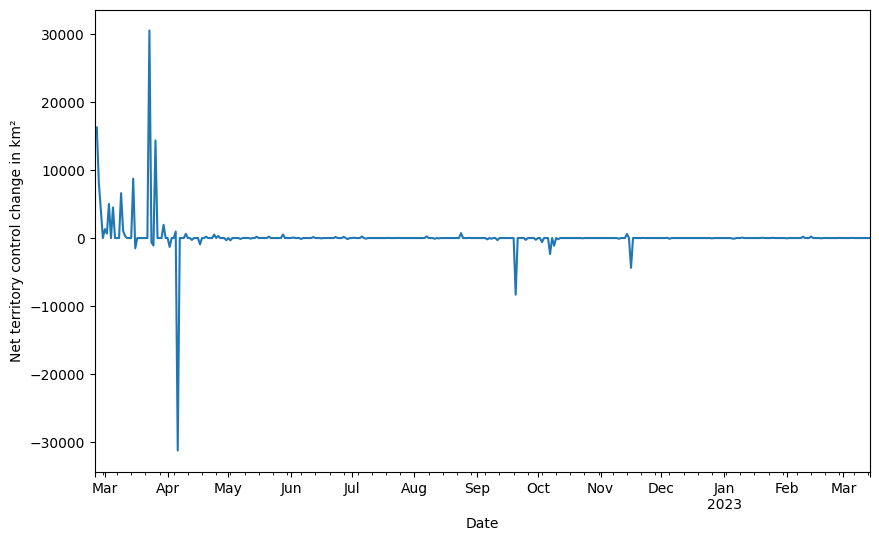

In [80]:
plt.figure()
df['change'].plot(xlabel='Date', ylabel='Net territory control change in km\u00b2', figsize=(10, 6))
plt.savefig('nzz_area_net.png', bbox_inches='tight', dpi=600)

In [81]:
df.area.groupby([lambda x: x.year, lambda x: x.month]).median()

date  date
2022  2        55124.215719
      3        85805.511951
      4        99647.586393
      5        99094.747089
      6        99950.445398
      7       100282.450683
      8       100422.450160
      9       100588.227216
      10       87438.574053
      11       85408.237258
      12       83447.211503
2023  1        83372.899541
      2        83754.050368
      3        83810.755795
Name: area, dtype: float64

<AxesSubplot: xlabel='date,date'>

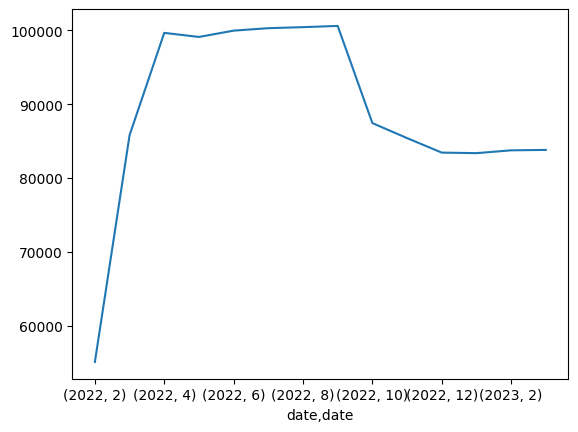

In [82]:
df.area.groupby([lambda x: x.year, lambda x: x.month]).median().plot()

<AxesSubplot: xlabel='date,date'>

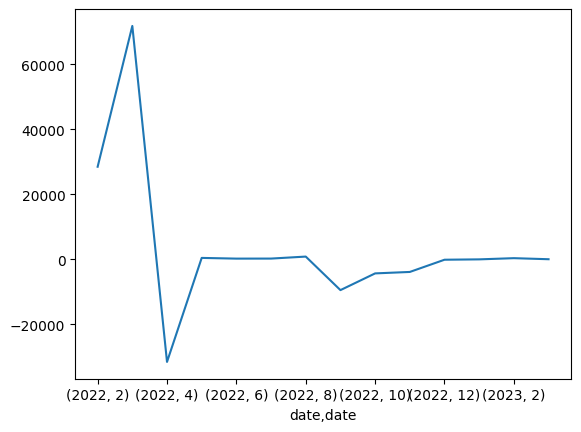

In [83]:
df.change.groupby([lambda x: x.year, lambda x: x.month]).sum().plot()

In [84]:
monthly = pd.DataFrame()
monthly['area'] = df.resample('M', label='right', offset=pd.Timedelta(days=0))['area'].median()
monthly['change'] = monthly['area'].diff()

In [85]:
df.corrwith(monthly, numeric_only=True)

area      0.632270
change   -0.235543
dtype: float64

<AxesSubplot: xlabel='date'>

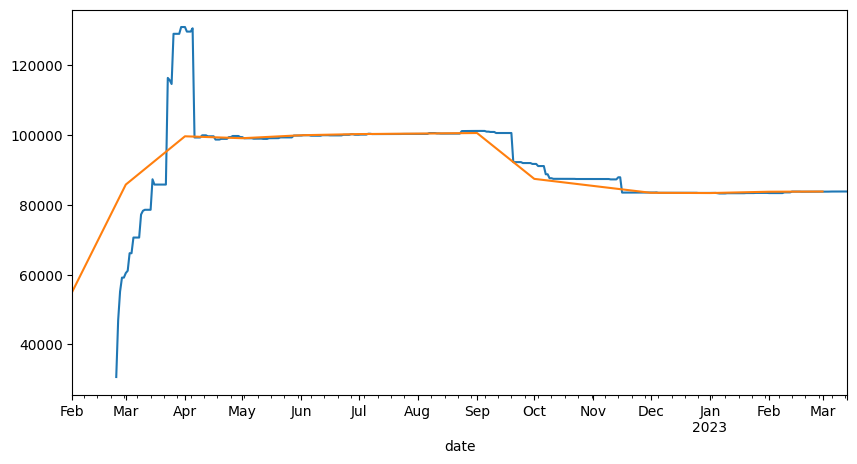

In [86]:
plt.figure()

ax = df['area'].plot(figsize=(10, 5))
# TODO: monthly plot is shifted 1 month left!
monthly['area'].plot(x=len(df['change'])+100, ax=ax)

<AxesSubplot: xlabel='date'>

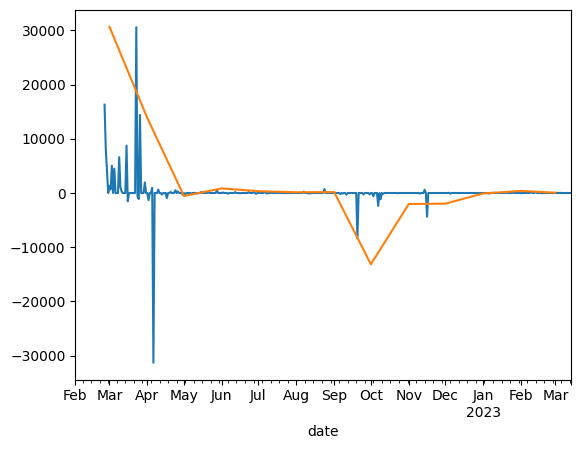

In [87]:
ax = df['change'].plot()
monthly['change'].plot(ax=ax)

In [88]:
monthly

,area,change
date,,
2022-02-28,55124.215719,NaN
2022-03-31,85805.511951,30681.296232
2022-04-30,99647.586393,13842.074442
2022-05-31,99094.747089,-552.839304
2022-06-30,99950.445398,855.698309
2022-07-31,100282.450683,332.005285
2022-08-31,100422.450160,139.999476
2022-09-30,100588.227216,165.777057
2022-10-31,87438.574053,-13149.653163


In [89]:
df

,area,features,change
date,,,
2022-02-24,30619.845722,"[{'type': 'Feature', 'properties': {'date': '2...",NaN
2022-02-25,46921.641963,"[{'type': 'Feature', 'properties': {'type': 'n...",16301.796241
2022-02-26,55124.215719,"[{'type': 'Feature', 'properties': {'type': 'n...",8202.573756
2022-02-27,59125.624178,"[{'type': 'Feature', 'properties': {'type': 'n...",4001.408459
2022-02-28,59125.624178,"[{'type': 'Feature', 'properties': {'type': 'n...",0.000000
...,...,...,...
2023-03-10,83820.518269,"[{'type': 'Feature', 'properties': {'type': 'n...",0.000000
2023-03-11,83820.518269,"[{'type': 'Feature', 'properties': {'type': 'n...",0.000000
2023-03-12,83820.518269,"[{'type': 'Feature', 'properties': {'type': 'n...",0.000000


<AxesSubplot: xlabel='date'>

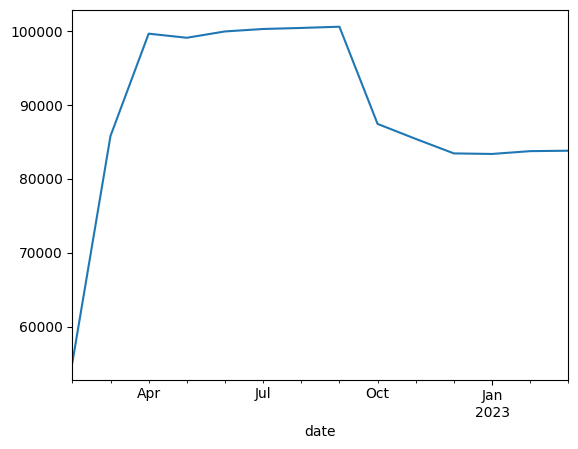

In [90]:
monthly['area'].plot()

In [91]:
y = np.array(df['area'].tolist())
n_breaks = 5

In [92]:
import ruptures as rpt

In [93]:
model = rpt.Dynp(model="l1")
model.fit(y)
breaks = model.predict(n_bkps=n_breaks-1)

In [94]:
breaks_rpt = []
for i in breaks:
    breaks_rpt.append(df['area'].index[i-1])
breaks_rpt = pd.to_datetime(breaks_rpt)
breaks_rpt

DatetimeIndex(['2022-03-20', '2022-04-04', '2022-09-21', '2022-11-15',
               '2023-03-14'],
              dtype='datetime64[ns]', freq=None)

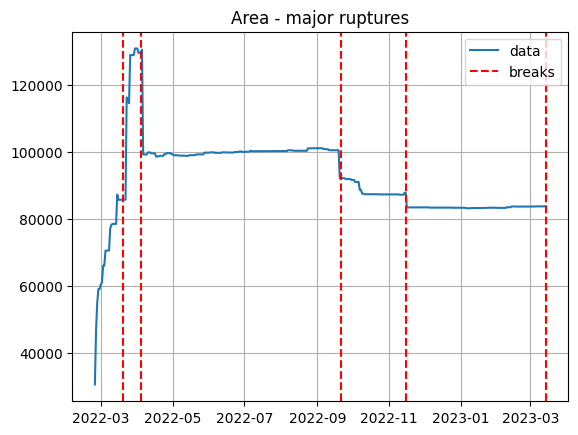

In [95]:
plt.plot(df['area'], label='data')
plt.title('Area - major ruptures')
print_legend = True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')
plt.grid()
plt.legend()
plt.show()

In [96]:
import jenkspy
breaks = jenkspy.jenks_breaks(y, n_classes=n_breaks-1)

In [97]:
breaks

[30619.84572184,
 70612.99436217999,
 92241.65110455001,
 101184.67103487,
 130980.02736292999]

In [98]:
breaks_jkp = []
for v in breaks:
    idx = df['area'].index[df['area'] == v][0]
    breaks_jkp.append(idx)
breaks_jkp

[Timestamp('2022-02-24 00:00:00'),
 Timestamp('2022-03-05 00:00:00'),
 Timestamp('2022-09-20 00:00:00'),
 Timestamp('2022-08-31 00:00:00'),
 Timestamp('2022-03-30 00:00:00')]

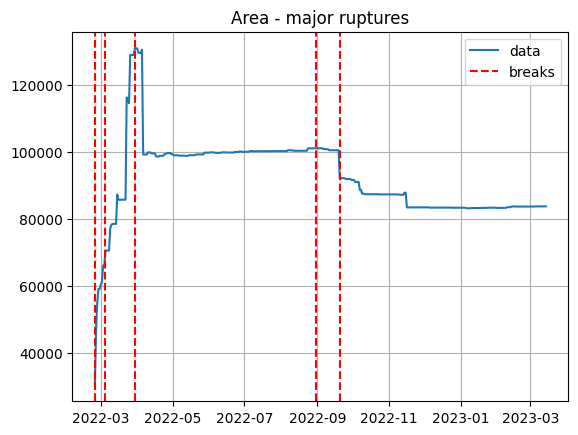

In [99]:
plt.plot(df['area'], label='data')
plt.title('Area - major ruptures')
print_legend = True
for i in breaks_jkp:
    if print_legend:
        plt.axvline(i, color='red', linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red', linestyle='dashed')
plt.grid()
plt.legend()
plt.show()